In [ ]:
import numpy as np
# import torch 
import terratorch

In [ ]:
test = {}
print(test.get('img_prefix'))

from osgeo import gdal
import rioxarray
testfile = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive\198_2019-02-15T10_06_39.586Z_2.tif'
info = gdal.Info(testfile)
print(info)

# def open_tiff(fname):
#     data = rioxarray.open_rasterio(fname)
#     return data.to_numpy()

# open_tiff(testfile)

In [85]:
import os
from urllib.parse import urlparse

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader,default_collate

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples,GeoDataset
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler,GeoSampler

import re
from typing import cast
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

class Sentinel2(RasterDataset):
    filename_glob = '*.tif'
    #198_2019-01-31T10_06_36.654Z_1.tif
    # filename_regex = r'^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])'
    # date_format = '%Y%m%dT%H%M%S'
    is_image = True
    separate_files = True
    all_bands = tuple([f'B0{i}' for i in range(1,14)])
    rgb_bands = ('B04', 'B03', 'B02')

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample['image'][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig
    
    def __getitem__(self,query):
        #dit is de source code van RasterDataSet.__getitem__() tot waar ik sample['test'] toevoeg
        #kan een work-around zijn?
        hits = self.index.intersection(tuple(query), objects=True)
        filepaths = cast(list[str], [hit.object for hit in hits])

        if not filepaths:
            raise IndexError(
                f'query: {query} not found in index with bounds: {self.bounds}'
            )

        if self.separate_files:
            data_list: list[torch.Tensor] = []
            filename_regex = re.compile(self.filename_regex, re.VERBOSE)
            for band in self.bands:
                band_filepaths = []
                for filepath in filepaths:
                    filename = os.path.basename(filepath)
                    directory = os.path.dirname(filepath)
                    match = re.match(filename_regex, filename)
                    if match:
                        if 'band' in match.groupdict():
                            start = match.start('band')
                            end = match.end('band')
                            filename = filename[:start] + band + filename[end:]
                    filepath = os.path.join(directory, filename)
                    band_filepaths.append(filepath)
                data_list.append(self._merge_files(band_filepaths, query))
            data = torch.cat(data_list)
        else:
            data = self._merge_files(filepaths, query, self.band_indexes)

        sample = {'crs': self.crs, 'bounds': query}

        data = data.to(self.dtype)
        if self.is_image:
            sample['image'] = data
        else:
            sample['mask'] = data

        sample['test'] = 1

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

In [83]:
root = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive'

dataset = Sentinel2(root)
print(dataset)

Sentinel2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-1585915.5339009934, maxx=1057978.5593479783, miny=4600624.042363878, maxy=6942656.59778398, mint=0.0, maxt=9.223372036854776e+18)
    size: 560


dict_keys(['crs', 'bounds', 'image', 'test'])


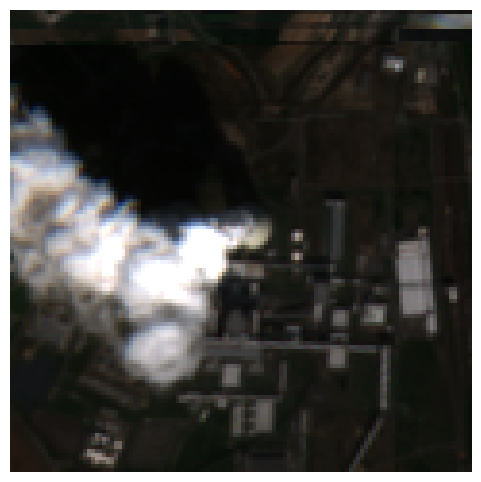

In [87]:
torch.manual_seed(1)
# root = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive'
# dataset = Sentinel2(root)
# print(dataset)    
sampler = RandomGeoSampler(dataset,size=120,length=1)
dataloader = DataLoader(dataset,sampler=sampler,collate_fn=stack_samples) 
# help(dataloader)
for batch in dataloader:
    sample = unbind_samples(batch)[0]
    print(sample.keys())
    dataset.plot(sample)
    plt.axis('off')
    plt.show()

In [73]:
help(RasterDataset)

Help on class RasterDataset in module torchgeo.datasets.geo:

class RasterDataset(GeoDataset)
 |  RasterDataset(paths: str | os.PathLike[str] | collections.abc.Iterable[str | os.PathLike[str]] = 'data', crs: rasterio.crs.CRS | None = None, res: float | None = None, bands: collections.abc.Sequence[str] | None = None, transforms: collections.abc.Callable[[dict[str, typing.Any]], dict[str, typing.Any]] | None = None, cache: bool = True) -> None
 |  
 |  Abstract base class for :class:`GeoDataset` stored as raster files.
 |  
 |  Method resolution order:
 |      RasterDataset
 |      GeoDataset
 |      torch.utils.data.dataset.Dataset
 |      typing.Generic
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, query: torchgeo.datasets.utils.BoundingBox) -> dict[str, typing.Any]
 |      Retrieve image/mask and metadata indexed by query.
 |      
 |      Args:
 |          query: (minx, maxx, miny, maxy, mint, maxt) coordinates to index
 |      
 | 